In [12]:
import pymc as pm
import netCDF4 as nc
import numpy as np
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt


events = ["GW150914","GW170104","GW170823","GW190519_153544",
          "GW190521","GW190521_074359","GW190706_222641",
          "GW190828_063405","GW200224_222234","GW200311_115853"]

ds = {}
points = {}

for event in events:
    fn = f"./ChargedResults/{event}/{event}-charged-posteriors.nc"
    a = nc.Dataset(fn)
    ds[event] = a
    points[event] = np.array([np.array(x) for x in zip(a['posterior']['chi'][:].flatten(),a['posterior']['Q_charge'][:].flatten())])

events_that_look_alright = ['GW150914','GW190519_153544',
                            'GW190521','GW190521_074359',
                            'GW190706_222641','GW200224_222234']

n_events = len(events_that_look_alright)

points_good = {k:v for k,v in points.items() if k in events_that_look_alright}

In [2]:
from sklearn.mixture import GaussianMixture

n_gauss = 20
GMMs = {}

for eventname, samples in points_good.items():
    GMMs[eventname] = GaussianMixture(n_components=n_gauss).fit(samples)

In [3]:
eventnames = list(GMMs.keys())
GMM_means = np.array([GMMs[eventname].means_ for eventname in eventnames])
GMM_weights = np.array([GMMs[eventname].weights_ for eventname in eventnames])
GMM_covariances = np.array([GMMs[eventname].covariances_ for eventname in eventnames])

In [5]:
GMM_means.shape

(6, 20, 2)

In [7]:
import pystan
analysis_data = {
             'Nobs': n_events,
             'NC': n_gauss,
             'weights': GMM_weights,
             'covs': GMM_covariances,
             'means': GMM_means
            }

compiled = pystan.StanModel(file='hierGRtest2D.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ed2a4114b2a26122cdb396b4f679006e NOW.
/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/x2/flf3cm9506vdxng0c9g04p440000gn/T/tmp_s0e447r/stanfit4anon_model_ed2a4114b2a26122cdb396b4f679006e_7014652151303798375.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [9]:
fit = compiled.sampling(data=analysis_data, iter=8000, chains=4)

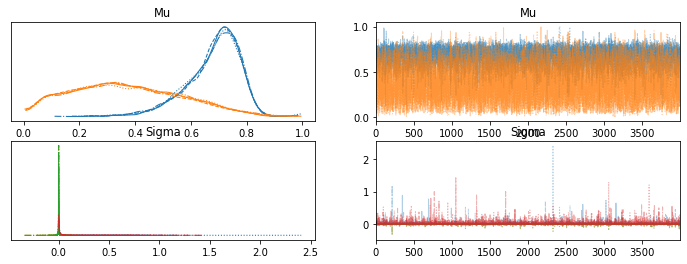

In [20]:
az.plot_trace(fit,
              var_names=['Mu', 'Sigma'],
              compact=True);

In [46]:
new_pystan_fit = az.convert_to_inference_data(fit)

In [47]:
new_pystan_fit.to_netcdf('new_pystan_fit.nc')

'new_pystan_fit.nc'

In [35]:
xpop_data = az.convert_to_inference_data(fit).posterior['xpop'].values

In [71]:
reshape = lambda x: x.reshape((x.shape[0]*x.shape[1],)+x.shape[2:])
xpop_data2 = reshape(xpop_data)

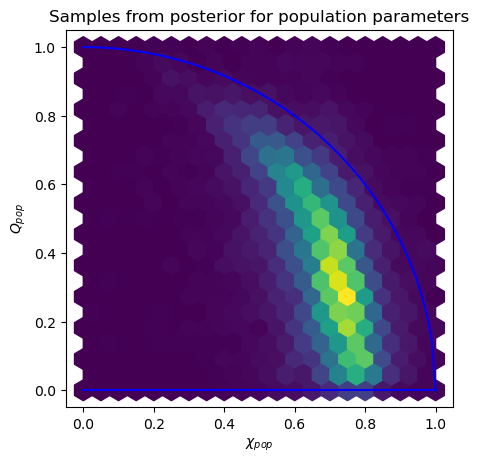

In [74]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)

ax.set_xlabel(r"$\chi_{pop}$")
ax.set_ylabel(r"$Q_{pop}$")
ax.hexbin(xpop_data2[:,0],xpop_data2[:,1],gridsize=20, extent=(0,1,0,1))
ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
ax.set_title("Samples from posterior for population parameters")

plt.show()

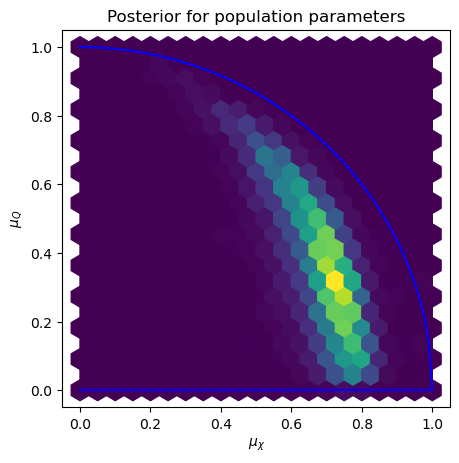

In [73]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)

new_data = reshape(new_pystan_fit.posterior['Mu'].values)

ax.set_xlabel(r"$\mu_\chi$")
ax.set_ylabel(r"$\mu_Q$")
ax.hexbin(new_data[:,0],new_data[:,1],gridsize=20, extent=(0,1,0,1))
ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
ax.set_title("Posterior for population parameters")

plt.show()

In [102]:
x = new_pystan_fit.posterior['Mu'].values

In [233]:
area_of_95_ellipse = lambda x: 5.991*np.pi*x[0]*x[1]
A = np.array([area_of_95_ellipse(np.sqrt(np.linalg.eig(i)[0]))/(np.pi/4) for i in reshape(new_pystan_fit.posterior['Sigma'].values)])

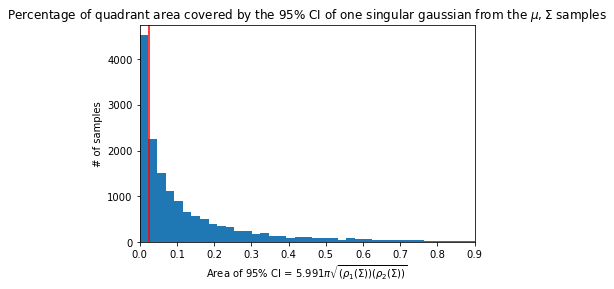

In [246]:
plt.hist(A, bins=400)
plt.title(r"Percentage of quadrant area covered by the 95% CI of one singular gaussian from the $\mu, \Sigma$ samples")
plt.xlabel(r"Area of 95% CI = $5.991\pi\sqrt{(\rho_1(\Sigma))(\rho_2(\Sigma))}$")
plt.ylabel(r"# of samples")
plt.axvline(0.025,c='r')
plt.xlim([0,0.9])
plt.show()

In [152]:
corr = lambda x: x[0,1]/np.sqrt(x[0,0]*x[1,1])
cs = np.array([corr(i) for i in reshape(new_pystan_fit.posterior['Sigma'].values)])

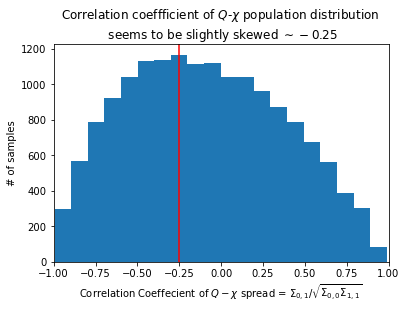

In [160]:
plt.hist(cs, bins=20)
plt.title("Correlation coeffficient of $Q$-$\chi$ population distribution \n seems to be slightly skewed $\sim -0.25$")
plt.xlabel(r"Correlation Coeffecient of $Q-\chi$ spread = $\Sigma_{0,1}/\sqrt{\Sigma_{0,0}\Sigma_{1,1}}$")
plt.ylabel(r"# of samples")
plt.axvline(-0.25,c='r')
plt.xlim([-1,1])
plt.show()

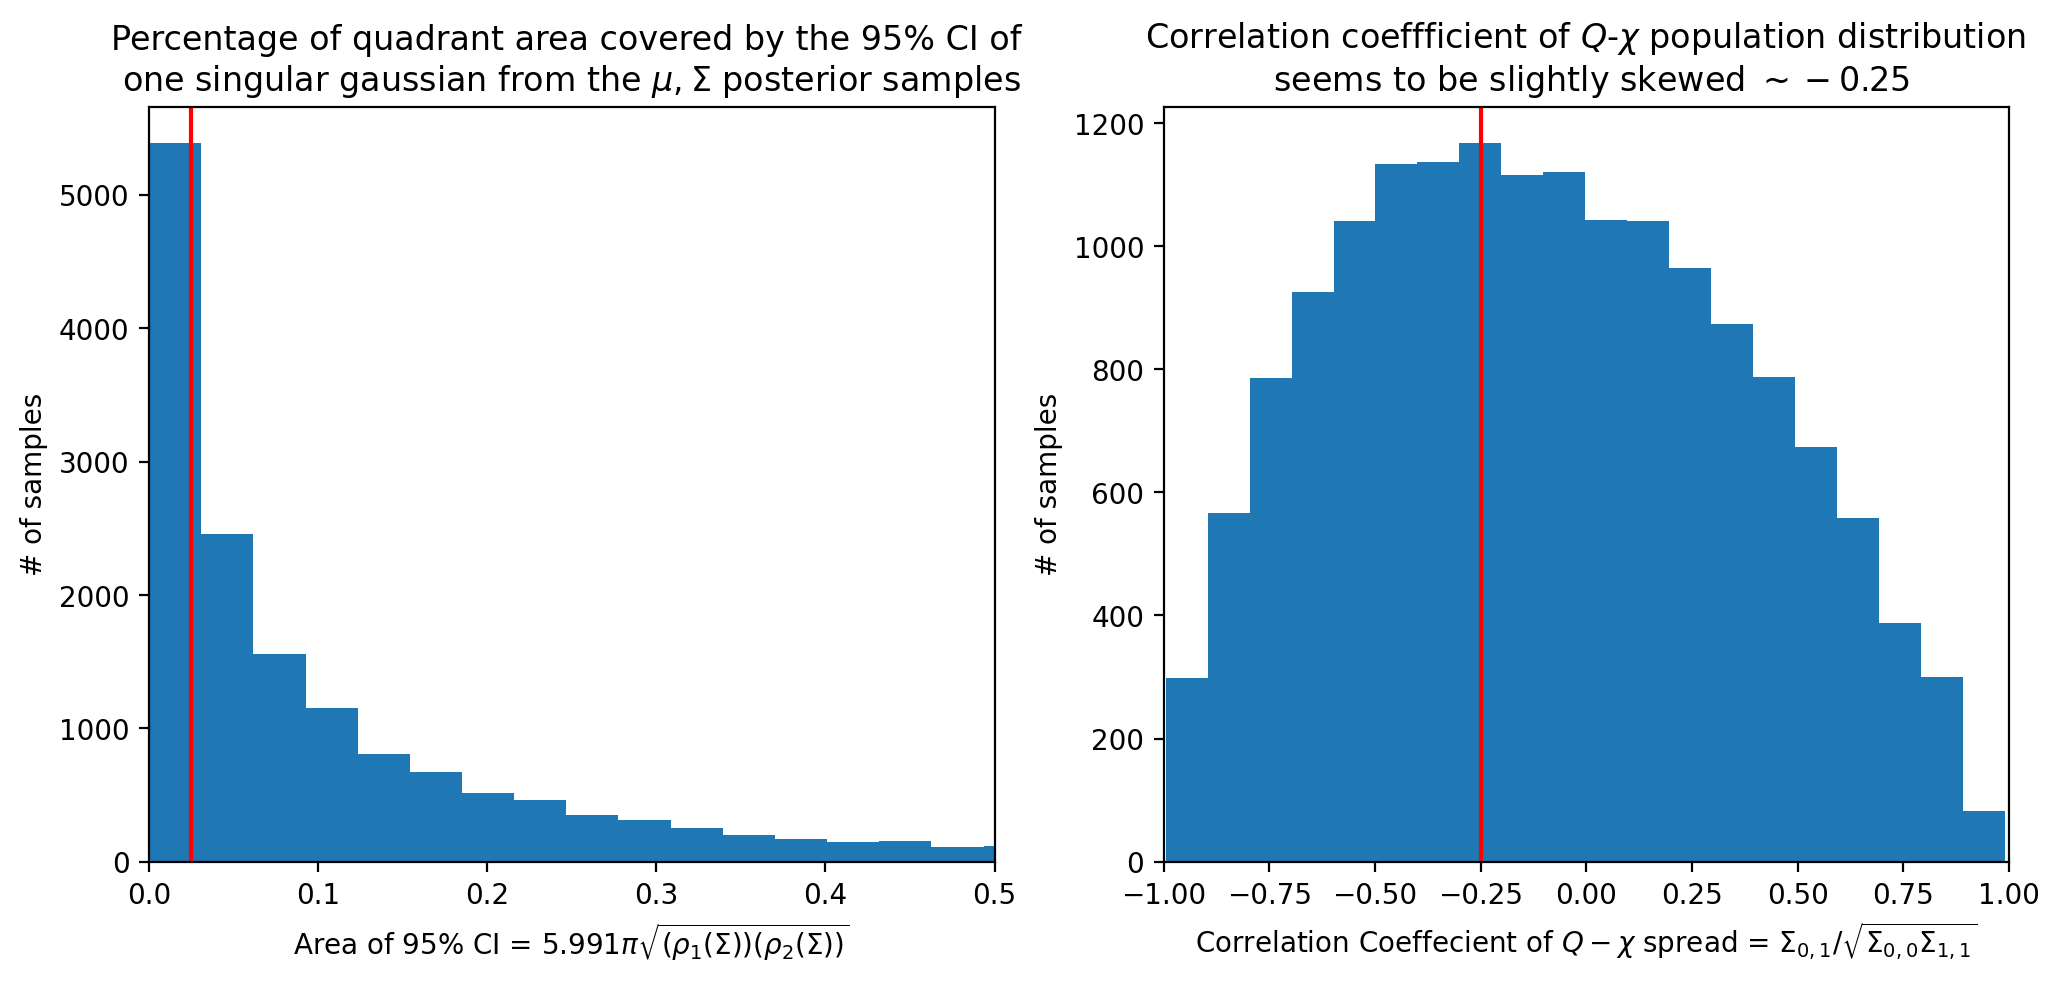

In [250]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=200)

axes[0].hist(A, bins=300)
axes[0].set_title(r"""Percentage of quadrant area covered by the 95% CI of 
one singular gaussian from the $\mu, \Sigma$ posterior samples""")
axes[0].set_xlabel(r"Area of 95% CI = $5.991\pi\sqrt{(\rho_1(\Sigma))(\rho_2(\Sigma))}$")
axes[0].set_ylabel(r"# of samples")
axes[0].axvline(0.025,c='r')
axes[0].set_xlim([0,0.5])

axes[1].hist(cs, bins=20)
axes[1].set_title("Correlation coeffficient of $Q$-$\chi$ population distribution \n seems to be slightly skewed $\sim -0.25$")
axes[1].set_xlabel(r"Correlation Coeffecient of $Q-\chi$ spread = $\Sigma_{0,1}/\sqrt{\Sigma_{0,0}\Sigma_{1,1}}$")
axes[1].set_ylabel(r"# of samples")
axes[1].axvline(-0.25,c='r')
axes[1].set_xlim([-1,1])

plt.show()


In [226]:
from matplotlib import patches
def gaussian_ellipse(mean, cov, alpha=0.5, color='yellow'):
    x,y = mean
    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(5.991) * np.sqrt(v)
    #v = 2.0 * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    el = patches.Ellipse(mean, v[0], v[1], 180.0 + angle, alpha=alpha, color=plt.get_cmap('viridis')(0.9))
    return el
    
def ax_plot_GMM_qchi(ax,gm, name=""):
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel(r"$\chi$")
    ax.set_ylabel(r"$Q$")
    ax.set_facecolor([0.25,0.0,0.4])
    for i in range(n_gauss):
        el = gaussian_ellipse(gm.means_[i], gm.covariances_[i], 
                              alpha=gm.weights_[i]/gm.weights_.max())
        ax.add_patch(el)
    ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
    ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
    ax.set_title(name)
    return ax

def ax_plot_means_covs_qchi(ax,means, covs , name=""):
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel(r"$\chi$")
    ax.set_ylabel(r"$Q$")
    ax.set_facecolor([0.25,0.0,0.4])
    for i in range(len(means)):
        el = gaussian_ellipse(means[i], covs[i], 
                              alpha=10/len(means))
        ax.add_patch(el)
    ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
    ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
    ax.set_title(name)
    return ax

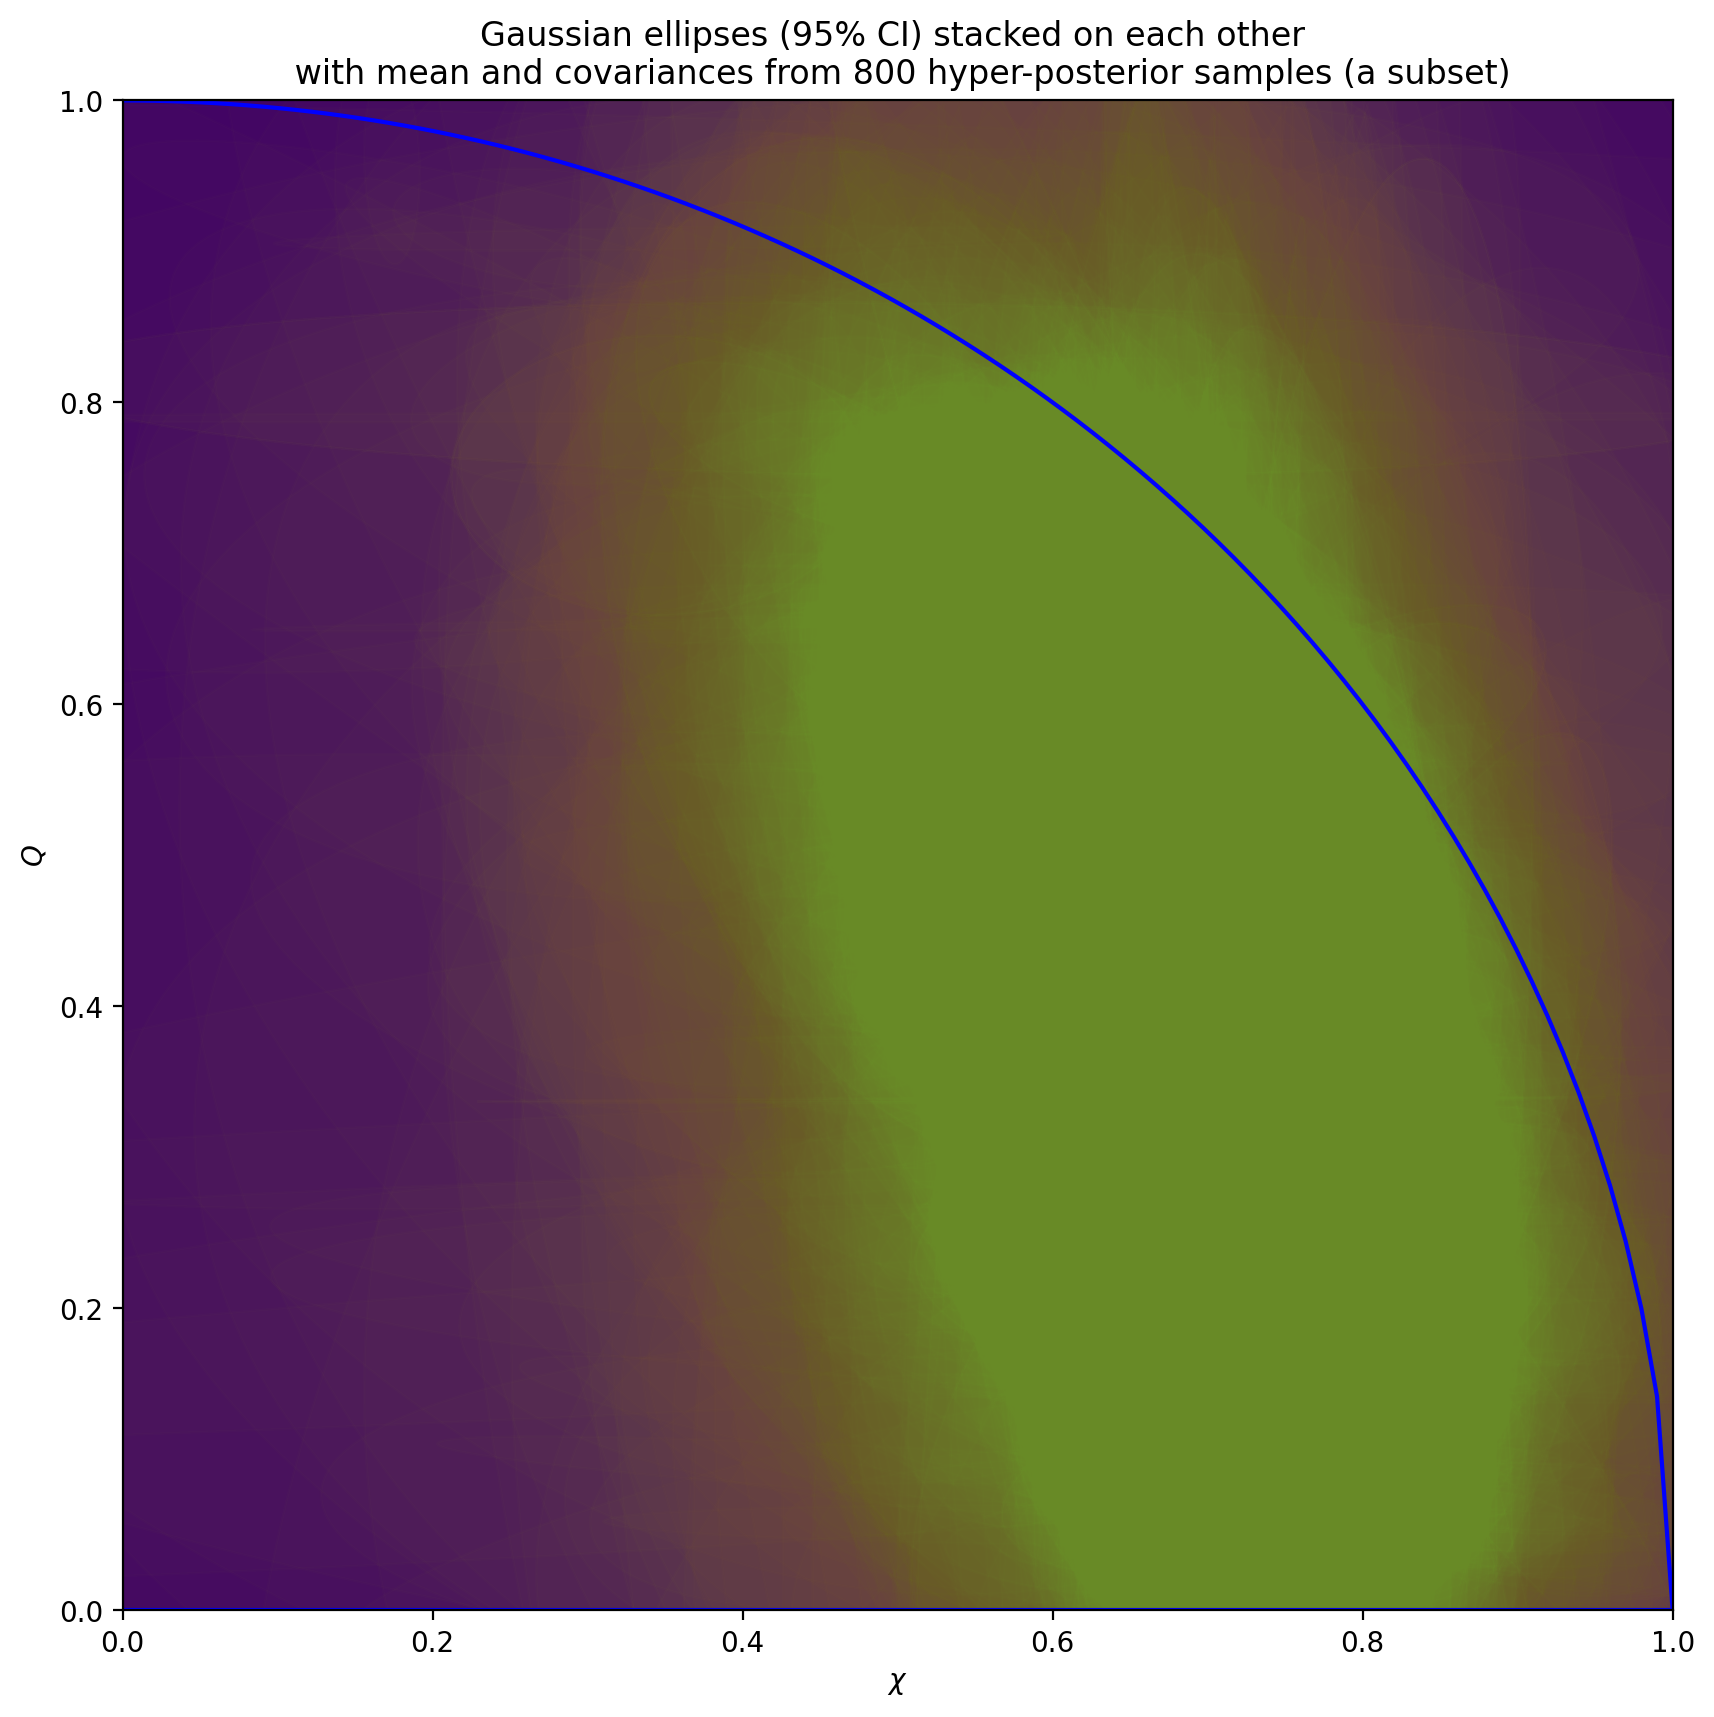

In [227]:
fig, ax = plt.subplots(1, figsize=(10,10), dpi=200)

sample_inds = np.random.choice(8000, 800)

ax = ax_plot_means_covs_qchi(ax, 
                             reshape(new_pystan_fit.posterior['Mu'].values)[sample_inds], 
                             reshape(new_pystan_fit.posterior['Sigma'].values)[sample_inds])

ax.set_title("Gaussian ellipses (95% CI) stacked on each other \n with mean and covariances from 800 hyper-posterior samples (a subset)")
plt.show()

In [91]:
import pystan
analysis_data = {
             'Nobs': n_events,
             'NC': n_gauss,
             'weights': GMM_weights,
             'covs': GMM_covariances,
             'means': GMM_means
            }

compiled_prior = pystan.StanModel(file='hierGRtest2D_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9a7823408f45c17c8188e0bf3dbe447a NOW.
/Users/asadh/opt/anaconda3/envs/Hierarchical_Analysis/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/x2/flf3cm9506vdxng0c9g04p440000gn/T/tmpsozquwj7/stanfit4anon_model_9a7823408f45c17c8188e0bf3dbe447a_7268262533638337377.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [96]:
fit_prior = compiled_prior.sampling(data=analysis_data, iter=8000, chains=4)

In [97]:
new_pystan_fit_prior = az.convert_to_inference_data(fit_prior)

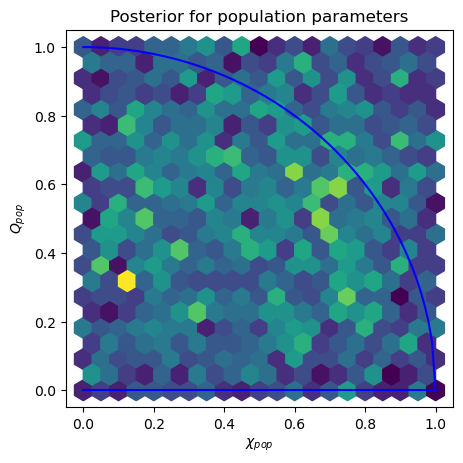

In [101]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)

new_data = reshape(new_pystan_fit_prior.posterior['xpop'].values)

ax.set_xlabel(r"$\chi_{pop}$")
ax.set_ylabel(r"$Q_{pop}$")
ax.hexbin(new_data[:,0],new_data[:,1],gridsize=20, extent=(0,1,0,1))
ax.plot(np.linspace(0,1,100), np.sqrt(1 - np.linspace(0,1,100)**2),c='b')
ax.plot(np.linspace(0,1,100), 0.0*np.linspace(0,1,100),c='b')
ax.set_title("Posterior for population parameters")

plt.show()